# **Skin Cancer Classification CNN Analysis**

##**Importing the Libraries Required**

In [ ]:
import torch
from torch import nn, optim
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import pyarrow.parquet as pq
import pandas as pd
import io
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Setting Library Seeds for Reproducibility**

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
seed_everything(464)

##**Preparing the Dataset**

In [ ]:
!unzip -oq /content/drive/MyDrive/cancer_dataset.zip

##**Implementing a Custom Dataset**



In [ ]:
class CancerDataset(Dataset):
    def __init__(self, parquet_file):
        """
        Args:
            parquet_file (str): Path to the Parquet file containing the dataset.
                                The dataset should have two columns: 'bytes' (image data) and 'label'.
        """
        data = pd.read_parquet(parquet_file).values

        self.image_bytes_list = [entry[0]['bytes'] if isinstance(entry[0], dict) else entry[0] for entry in data]
        self.class_list = [entry[1] for entry in data]

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.image_bytes_list)

    def __getitem__(self, data_id):
        """
        Fetches the image and label for a given index.
        """
        image_bytes = self.image_bytes_list[data_id]
        image_class = self.class_list[data_id]

        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        image_tensor = self.transform(image)

        return image_class, image_tensor

In [ ]:
train_dataset = CancerDataset("/content/balanced_skin_cancer_dataset_train_2.parquet")
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_ratio = 0.125
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
val_dataloader = DataLoader(val_subset, batch_size=128, shuffle=False)

test_dataset = CancerDataset("/content/balanced_skin_cancer_dataset_test.parquet")
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

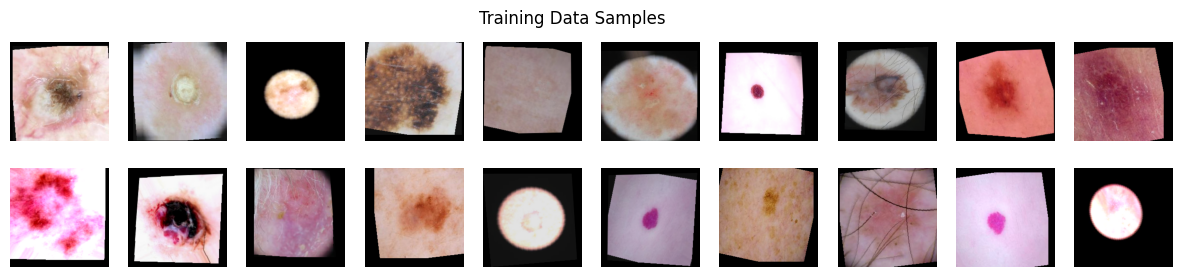

In [ ]:
_, images = next(iter(train_dataloader))
images = images.numpy()

num_rows = 2
num_columns = 10

figure, axis_array = plt.subplots(num_rows, num_columns, figsize=(num_columns*1.5,num_rows*1.5))
figure.suptitle("Training Data Samples")

im_id = 0
for row_id in range(num_rows):
  for column_id in range(num_columns):
    # The channel dimension of the image is moved to the last index
    # to make the shape of the image compatible with Matplotlib
    image = images[im_id].transpose(1,2,0)
    # Value range is mapped from [-1,1] to [0,1]
    image = (image + 1) / 2
    if num_rows == 1:
      current_axis = axis_array[column_id]
    else:
      current_axis = axis_array[row_id, column_id]
    current_axis.axis('off')
    current_axis.imshow(image)
    im_id += 1

##**Constructing a Classifier Network**

In [ ]:
class CancerClassifier(nn.Module):
    def __init__(self):
        super(CancerClassifier, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x112x112
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64x56x56
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128x28x28
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256x14x14
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=50176, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=8)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.flatten(x)
        x = self.fc_layers(x)

        return x

##**Implementing the Training Loop**


In [ ]:
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CancerClassifier().to(device)
checkpoint = torch.load('/content/drive/MyDrive/model_checkpoint2.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = Adam(model.parameters(), lr=0.000025)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float('inf')
patience_counter = 0
patience_limit = 10

<ipython-input-13-e0ddadbcdc96>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/model_checkpoint.pth')


In [ ]:
num_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)
num_epochs = 400

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_image_class, batch_image_tensor in train_dataloader:
        batch_image_tensor, batch_image_class = batch_image_tensor.to(device), batch_image_class.to(device)
        optimizer.zero_grad()
        outputs = model(batch_image_tensor)
        loss = loss_func(outputs, batch_image_class)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / num_batches
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_image_class, val_image_tensor in val_dataloader:
            val_image_tensor, val_image_class = val_image_tensor.to(device), val_image_class.to(device)
            val_outputs = model(val_image_tensor)
            val_loss = loss_func(val_outputs, val_image_class)
            running_val_loss += val_loss.item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_image_class.size(0)
            correct += (predicted == val_image_class).sum().item()

    avg_val_loss = running_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    scheduler.step(avg_val_loss)
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.2f}% - LR: {current_lr:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")

    if patience_counter >= patience_limit:
        print("Early stopping triggered. Terminating training.")
        break

Epoch 1/400 - Train Loss: 0.7991 - Val Loss: 0.6864 - Val Acc: 73.86% - LR: 0.000050
Epoch 2/400 - Train Loss: 0.7880 - Val Loss: 0.7029 - Val Acc: 73.57% - LR: 0.000050
No improvement for 1 epochs.
Epoch 3/400 - Train Loss: 0.7883 - Val Loss: 0.7146 - Val Acc: 71.95% - LR: 0.000050
No improvement for 2 epochs.
Epoch 4/400 - Train Loss: 0.7829 - Val Loss: 0.6927 - Val Acc: 73.52% - LR: 0.000050
No improvement for 3 epochs.
Epoch 5/400 - Train Loss: 0.7788 - Val Loss: 0.6778 - Val Acc: 74.24% - LR: 0.000050
Epoch 6/400 - Train Loss: 0.7747 - Val Loss: 0.7022 - Val Acc: 73.24% - LR: 0.000050
No improvement for 1 epochs.
Epoch 7/400 - Train Loss: 0.7713 - Val Loss: 0.6794 - Val Acc: 74.33% - LR: 0.000050
No improvement for 2 epochs.
Epoch 8/400 - Train Loss: 0.7727 - Val Loss: 0.6609 - Val Acc: 74.29% - LR: 0.000050
Epoch 9/400 - Train Loss: 0.7614 - Val Loss: 0.7009 - Val Acc: 73.33% - LR: 0.000050
No improvement for 1 epochs.
Epoch 10/400 - Train Loss: 0.7700 - Val Loss: 0.6695 - Val Ac

KeyboardInterrupt: 

In [ ]:
import torch
import os

def save_model(model, optimizer, epoch, loss, path):
    """
    Save the current state of the model, optimizer, and epoch information.

    Args:
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer used during training.
        epoch (int): Current epoch number.
        loss (float): Current loss value.
        path (str): Path to save the model checkpoint.
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }

    torch.save(checkpoint, path)
    print(f"Model saved at epoch {epoch} with loss {loss:.4f}")


In [ ]:
save_path = '/content/drive/MyDrive/model_checkpoint2.pth'
save_model(model, optimizer, 20, 0.7254, path = save_path)

Model saved at epoch 20 with loss 0.7254


##**Plotting the Training Loss Curves**

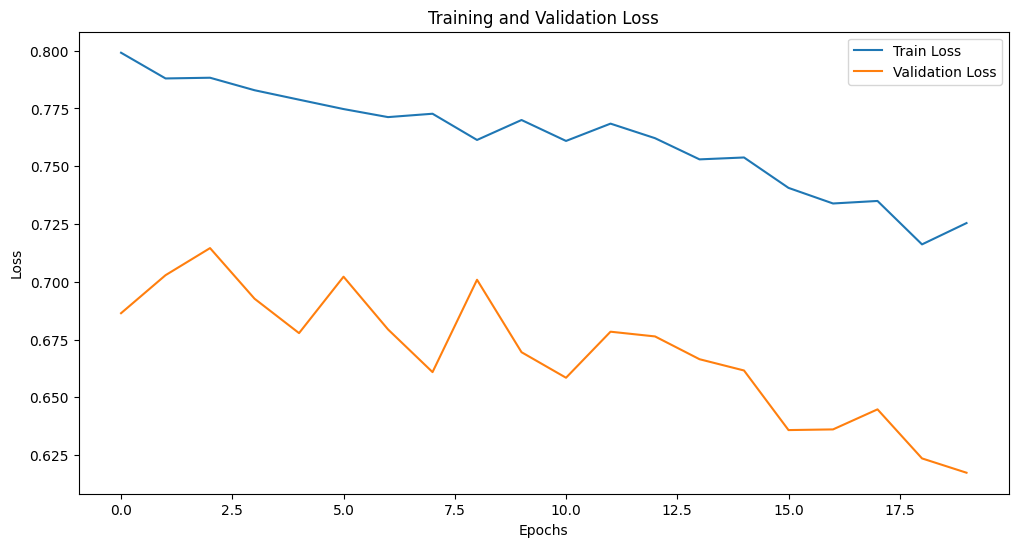

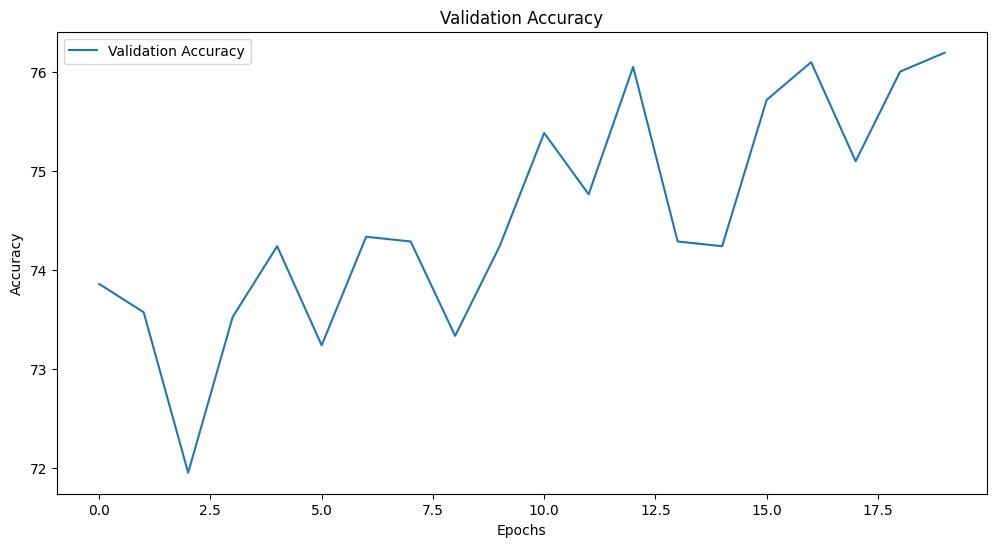

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

##**Evaluating the Model**

In [ ]:
model.eval()

pred_class_list = []
gt_class_list = []
test_accuracies = []

with torch.no_grad():
    for batch_image_class, batch_image_tensor in test_dataloader:
        if torch.cuda.is_available():
            batch_image_tensor = batch_image_tensor.cuda()
            batch_image_class = batch_image_class.cuda()

        batch_outputs = model(batch_image_tensor)

        batch_image_class = batch_image_class.cpu().numpy()
        batch_outputs = batch_outputs.cpu().numpy()
        pred_classes = np.argmax(batch_outputs, axis=1)

        pred_class_list.extend(pred_classes)
        gt_class_list.extend(batch_image_class)

In [ ]:
# Calculate overall accuracy
accuracy = accuracy_score(gt_class_list, pred_class_list)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(gt_class_list, pred_class_list))

Accuracy: 0.6968
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       524
           1       0.64      0.69      0.66       524
           2       0.53      0.50      0.52       524
           3       0.88      0.95      0.91       524
           4       0.57      0.42      0.49       524
           5       0.65      0.70      0.67       524
           6       0.65      0.67      0.66       524
           7       0.96      0.99      0.98       524

    accuracy                           0.70      4192
   macro avg       0.69      0.70      0.69      4192
weighted avg       0.69      0.70      0.69      4192

